# Unsupervised Learning

### Comprises clustering and density estimation.

## Semi-Supervised Learning with KMeans

### Definition:
__Semi-Supervised Learning:__ combination of unsupervised and supervised algorithms using a __dataset__ that is __partially labeled__. Generally only a few labeled instances are available. Thus the majority of the dataset is unlabeled.<br>
__Clustering:__ identify __similar instances__ and assign them to clusters.<br>
__KMeans:__ clustering algorithm
1. run algorithms several times to avoid suboptimal solutions
1. specify number of clusters
1. bad on nonspherical shapes

### load digits dataset

#### digits dataset:
1. MNIST-like dataset
2. 1797 grayscale 8x8 images of digits 0 to 9

In [194]:
from sklearn.datasets import load_digits

In [195]:
X_digits, y_digits = load_digits(return_X_y=True)

In [196]:
X_digits.shape

(1797, 64)

In [197]:
from sklearn.model_selection import train_test_split

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)  #test: 25% of full dataset

In [199]:
X_train.shape, y_train.shape  #train: 75% of full dataset

((1347, 64), (1347,))

### classification with full dataset

#### multiclass classification with one-versus-the-rest (ovr) strategy: 
1. train 10 binary classifiers, one for each digit
2. classify image: select classifier with highest scores

In [200]:
import numpy as np

In [201]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [202]:
from sklearn.linear_model import LogisticRegression

In [203]:
#solver: algorithm to use in optimization problem; max_iter: maximum number of iterations for solvers to converge;

In [204]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42) 
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [205]:
log_reg.score(X_test, y_test)

0.9688888888888889

### classification with restricted dataset (50 instances)

In [206]:
n_labeled = 50  #on average, 5 images per class (digit)

In [207]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])  #restricted dataset
log_reg.score(X_test, y_test)

0.8333333333333334

### clustering with K-Means

#### short explanation of K-Means algorithm:
start: choose centroids randomly<br>
repeat until centroids stable:<br>
1. label instances (assign instances to centroids)<br>
1. update centroids (mean of instances within cluster)

In [208]:
k = 50  #50 clusters to be compared with 50 random instances from the dataset

In [209]:
from sklearn.cluster import KMeans

In [210]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)  #distance from each instance to every centroid
representative_digit_idx = np.argmin(X_digits_dist, axis=0)  #index of closest instance to centroid 0,1, ...,49
X_representative_digits = X_train[representative_digit_idx]  #images according to closest instance to centroid 0,...,49

In [211]:
X_digits_dist.shape

(1347, 50)

In [212]:
X_representative_digits.shape

(50, 64)

In [213]:
np.unique(kmeans.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

### images of 50 representative digits

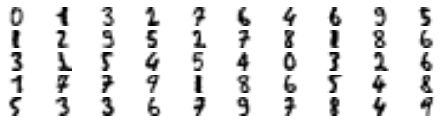

In [214]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

### manually labelling each image

In [215]:
y_representative_digits = np.array([
    0,1,3,2,7,6,4,6,9,5,
    1,2,9,5,2,7,8,1,8,6,
    3,1,5,4,5,4,0,3,2,6,
    1,7,7,9,1,8,6,5,4,8,
    5,3,3,6,7,9,7,8,4,9])

### classification with restricted representative dataset (50 instances)

In [216]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9244444444444444

### classification with full label propagated dataset 

In [217]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [218]:
X_train.shape, y_train_propagated.shape  

((1347, 64), (1347,))

In [219]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)  #train with full dataset

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [220]:
log_reg.score(X_test, y_test)  #accuracy of full label propagated dataset

0.9377777777777778

### classification with partially label propagated dataset 

In [221]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [222]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [223]:
X_train_partially_propagated.shape, y_train_partially_propagated.shape

((289, 64), (289,))

In [224]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)  #train with restricted dataset

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

### accuracy degradation compared with full label propagated dataset 

In [225]:
log_reg.score(X_test, y_test)  #accuracy of partially label propagated dataset; degraded accuracy!

0.9222222222222223

In [226]:
y_train_partially_propagated.shape, y_train[partially_propagated].shape

((289,), (289,))

In [227]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])  #check quality of partially propagated dataset

0.9896193771626297

### classification with true partially propagated dataset 

In [228]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train[partially_propagated])  #train with true partially propagated dataset

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [229]:
log_reg.score(X_test, y_test)

0.9355555555555556

### summary
<table style="width:80%">
<tr>
<th>digits dataset</th>
<th>accuracy</th>
</tr>
<tr>
<td>full dataset (baseline)</td>
<td>96.9%</td>
</tr>
<tr>
<td>restricted dataset</td>
<td>83.3%</td>
</tr>    
<tr>
<td>restricted representative dataset (KMeans)</td>
<td>92.4%</td>
</tr>    
<tr>
<td>full label propagated dataset (KMeans)</td>
<td>93.8%</td>
</tr>    
<tr>
<td>partially label propagated dataset (KMeans)</td>
<td>92.2%</td>
</tr>    
<tr>
<td>true partially propagated dataset</td>
<td>93.6%</td>
</tr>    
</table>

### conclusion
1. given a partially labeled dataset, clustering may be an effective way to label the dataset automatically.
1. provide reasonable results in a Semi-Supervised Learning setting.
1. KMeans algorithm applied to the digits dataset achieves an accuracy rate of about 93.8% compared to the baseline of 96.9%.